In [1]:
# Importing required packages
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.ticker as ticker

In [2]:
# Importing location data
import pandas as pd
loc_data = pd.read_csv("./air-quality-data-from-extensive-network-of-sensors/sensor_locations.csv")

In [3]:
# Separating latitudes and longitudes and add them to their repective lists
lats = loc_data['latitude'].tolist()
lons = loc_data['longitude'].tolist()

In [4]:
# Importing PM and Meteorological data from monthwise files for the year 2017. The data is recorded for each hour
# The data is stored in the dataframe "frame"

filenames = ["january-2017.csv","february-2017.csv","march-2017.csv","april-2017.csv","may-2017.csv","june-2017.csv","july-2017.csv","august-2017.csv","september-2017.csv","october-2017.csv","november-2017.csv","december-2017.csv"]
path =r'./air-quality-data-from-extensive-network-of-sensors/'

li = []

for filename in filenames:
    fname = path + filename 
    df = pd.read_csv(fname, index_col=None, header=0)
    li.append(df)

frame = pd.concat(li, axis=0, ignore_index=True)


In [5]:
# Removing data from months January and February since most sensors did not work during those months

frame['UTC time'] = pd.to_datetime(frame['UTC time'])

# Drop first two months since temp and humidity were not calibrated
frame['Month'] = frame['UTC time'].dt.month
frame = frame[frame['Month'] != 1]
frame = frame[frame['Month'] != 2]

In [7]:
# We have n = 7177
frame.shape

(7177, 338)

In [9]:
# Setup for selecting 30 sensors that were running for most of the ten months with only a few missing values

# The latitudes of the sensors are stored in the list "lats_30"
# The longitudes of the sensors are stored in the list "lons_30"
# The sensor ids to be selected are stored in a list "sens"

sens = [169,170,171,173,176,177,179,181,182,183,184,189,192,194,196,201,204,212,214,215,218,219,220,221,222,223,225,226,228,263]
loc_data_30 = loc_data[loc_data['id'].isin(sens)] 
lats_30 = loc_data_30['latitude'].tolist()
lons_30 = loc_data_30['longitude'].tolist()
sens = str(sens)

In [24]:
# Plotting location of the 30 sensors

import plotly 
plotly.tools.set_credentials_file(username='gauravsm', api_key='yDhHOD5ueKUYqYb9xKpo')


import plotly.plotly as py
import plotly.graph_objs as go

mapbox_access_token = 'pk.eyJ1IjoiZ2F1cmF2c20iLCJhIjoiY2p2YzQ1dmtuMG02MzN5cDg1d3dsemttaCJ9.lV389_9mffK9Nk4O6Nzv_A'

#datas = []

data = [
    go.Scattermapbox(
        lat=lats_30,
        lon=lons_30,
        mode='markers',
        marker=go.scattermapbox.Marker(
            size=14
        ),
        text=loc_data_30['id'].to_list(),
    ),
    
]


layout = go.Layout(
    title = '30 Sensors Distributed Across Krakow, Poland',
    autosize=True,
    hovermode='closest',
    showlegend = False,
    mapbox=go.layout.Mapbox(
        accesstoken=mapbox_access_token,
        bearing=0,
        center=go.layout.mapbox.Center(
            lat=50.057748,
            lon=19.961375
        ),
        pitch=0,
        zoom=9.8
    ),

)

fig = go.Figure(data, layout=layout)
py.iplot(fig, filename='KrakowPlot1_30sensors')

In [11]:
# Selecting data of 30 sensors in a new dataframe "frame_coldrop" from data of 56 sensors stored in dataframe "frame"

cols = [c for c in frame.columns if c.lower()[:3] in sens]
cols = cols + ['UTC time']
frame_coldrop = frame[cols]

In [12]:
# Replacing zeros in the time series data with previous values

frame_coldrop = frame_coldrop.fillna(0)
for i in range(180):
    frame_coldrop[frame_coldrop.columns[i]] = frame_coldrop[frame_coldrop.columns[i]].replace(to_replace=0, method='ffill')

In [13]:
# Changing data frame name from "frame_coldrop" to "frame_red"

frame_red = frame_coldrop

In [14]:
# Selecting only temp measurements and storing in a dataframe "temp"

temp = frame_red.filter(regex='temp')
temp = temp.join(frame_red['UTC time'])
temp['UTC time'] = pd.to_datetime(temp['UTC time'])

In [17]:
# Selecting only pressure measurements and storing in a dataframe "pres"

pres = frame_red.filter(regex='pres')
pres = pres.join(frame_red['UTC time'])
pres['UTC time'] = pd.to_datetime(pres['UTC time'])

In [18]:
# Selecting only pm10 measurements and storing in a dataframe "pm10"

pm10 = frame_red.filter(regex='pm10')
pm10 = pm10.join(frame_red['UTC time'])
pm10['UTC time'] = pd.to_datetime(pm10['UTC time'])

In [19]:
# Selecting only pm25 measurements and storing in a dataframe "pm25"

pm25 = frame_red.filter(regex='pm25')
pm25 = pm25.join(frame_red['UTC time'])
pm25['UTC time'] = pd.to_datetime(pm25['UTC time'])

In [20]:
# Selecting only humidity measurements and storing in a dataframe "hum"

hum = frame_red.filter(regex='hum')
hum = hum.join(frame_red['UTC time'])
hum['UTC time'] = pd.to_datetime(hum['UTC time'])

C:\Users\IVN\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


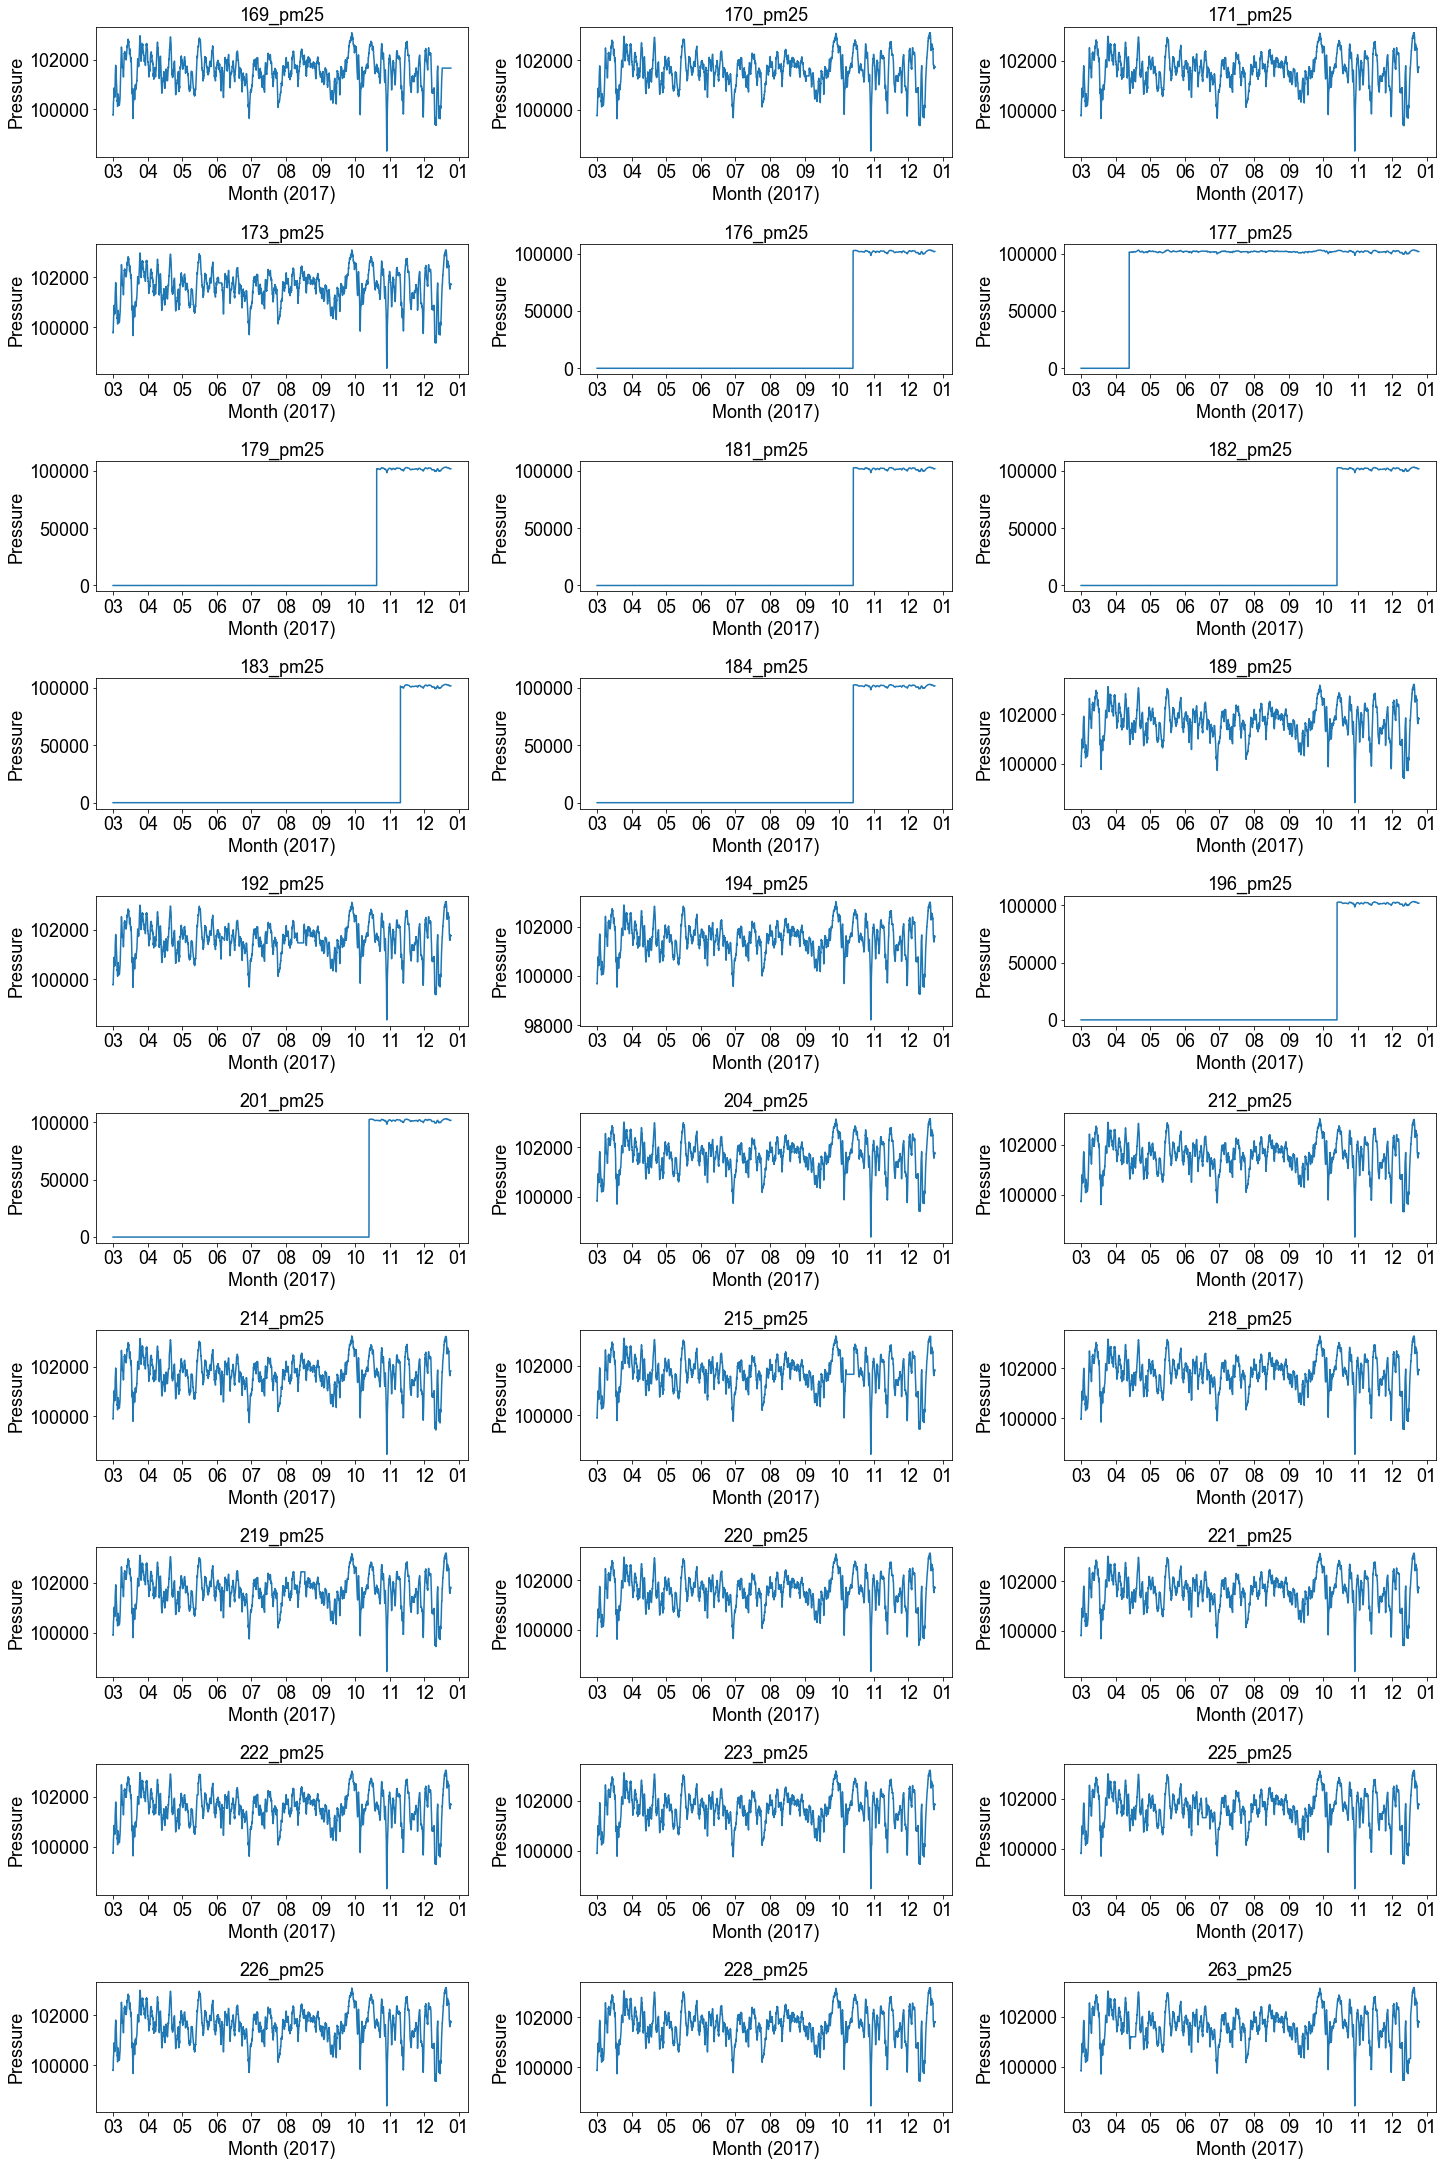

In [21]:
# Plotting time series data of pressure values for all 30 sensors 
# The pressure was not recorded correctly by some sensors and all other sensors have the same pressure values 
# across the time scale
# Hence, pressure feature was dropped for model development

rcParams['font.family'] = 'arial'
import matplotlib.dates as mdates
from scipy.signal import savgol_filter

f1 = plt.figure(figsize=(20,30))

for i in range(30):

    ax1 = f1.add_subplot(10,3,1+i)

    x = pres['UTC time']
    y = pres.iloc[:,i]
    ax1.plot(x,y)

    ax1.set_xlabel('Month (2017)',fontsize=18)
    ax1.set_ylabel('Pressure',fontsize=18)
    ax1.tick_params(axis='x', labelsize=18)
    ax1.tick_params(axis='y', labelsize=18)
    ax1.xaxis.set_major_formatter(mdates.DateFormatter("%m"))
    ax1.set_title(pm25.columns[i],fontsize=18)
    
plt.tight_layout(pad=0.4, w_pad=2, h_pad=2)
#f1.savefig('pm25_6sensors.png')

In [23]:
# Plotting normalized average pm25 over 10 months for 30 sensors 

import numpy as np
pm25_sum = np.array(pm25.sum().tolist())
pm25_sum_norm = ( pm25_sum - min(pm25_sum) ) / (max(pm25_sum) - min(pm25_sum))

Z = pm25_sum_norm


import plotly 
plotly.tools.set_credentials_file(username='gauravsm', api_key='yDhHOD5ueKUYqYb9xKpo')


import plotly.plotly as py
import plotly.graph_objs as go

mapbox_access_token = 'pk.eyJ1IjoiZ2F1cmF2c20iLCJhIjoiY2p2YzQ1dmtuMG02MzN5cDg1d3dsemttaCJ9.lV389_9mffK9Nk4O6Nzv_A'

limits = [(0,0.2),(0.2,0.4),(0.4,0.6),(0.6,0.8),(0.8,1)]
colors = ["rgb(204,255,255)","rgb(0,116,217)","rgb(255,133,27)","rgb(255,65,54)","rgb(133,20,75)"]
cities = []
scale = 5000

lons = np.array(lons_30)
lats = np.array(lats_30)

for i in range(len(limits)-1):
    lim = limits[i]
    idx = np.where(np.logical_and(Z>=lim[0], Z<lim[1]))[0]
    city = go.Scattermapbox(
        lon = lons[idx],
        lat = lats[idx],
        mode='markers',
        marker=go.scattermapbox.Marker(
            size=14,
            color = colors[i],
        ),
        name = '{0} - {1}'.format(lim[0],lim[1]) 
    
    )
    cities.append(city)
    
i=i+1    
lim = limits[i]
idx = np.where(np.logical_and(Z>=lim[0], Z<=lim[1]))[0]
city = go.Scattermapbox(
    lon = lons[idx],
    lat = lats[idx],
    mode='markers',
    marker=go.scattermapbox.Marker(
        size=14,
        color = colors[i],
    ),
    name = '{0} - {1}'.format(lim[0],lim[1]) 

)
cities.append(city)

layout = go.Layout(
    title = 'Normalized PM2.5 Distribution 2017',
    autosize=True,
    hovermode='closest',
    showlegend = True,
    mapbox=go.layout.Mapbox(
        accesstoken=mapbox_access_token,
        bearing=0,
        center=go.layout.mapbox.Center(
            lat=50.057748,
            lon=19.961375
        ),
        pitch=0,
        zoom=9.8
    ),

)

fig = go.Figure(data=cities, layout=layout)
py.iplot(fig, filename='Norm_Average_PM25_2017')

C:\Users\IVN\Anaconda3\lib\site-packages\IPython\core\display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



In [35]:
# Selecting 6 sensors out of 30 for further evaluation through plots

import plotly 
plotly.tools.set_credentials_file(username='gauravsm', api_key='yDhHOD5ueKUYqYb9xKpo')


import plotly.plotly as py
import plotly.graph_objs as go

mapbox_access_token = 'pk.eyJ1IjoiZ2F1cmF2c20iLCJhIjoiY2p2YzQ1dmtuMG02MzN5cDg1d3dsemttaCJ9.lV389_9mffK9Nk4O6Nzv_A'

#datas = []

data1 = [
    go.Scattermapbox(
        lat=lats_30[6:],
        lon=lons_30[6:],
        mode='markers',
        marker=go.scattermapbox.Marker(
            size=14
        ),
        text=loc_data_30['id'].to_list(),
    ),
    
]

data2 = [
    go.Scattermapbox(
        lat=lats_30[:6],
        lon=lons_30[:6],
        mode='markers',
        marker=go.scattermapbox.Marker(
            size=14
        ),
        text=loc_data_30['id'].to_list(),
    ),
    
]

data = data1 + data2

layout = go.Layout(
    title = 'Sensors',
    autosize=True,
    hovermode='closest',
    showlegend = False,
    mapbox=go.layout.Mapbox(
        accesstoken=mapbox_access_token,
        bearing=0,
        center=go.layout.mapbox.Center(
            lat=50.057748,
            lon=19.961375
        ),
        pitch=0,
        zoom=9.8
    ),

)

fig = go.Figure(data, layout=layout)
py.iplot(fig, filename='KrakowPlot2_6_30sensors')

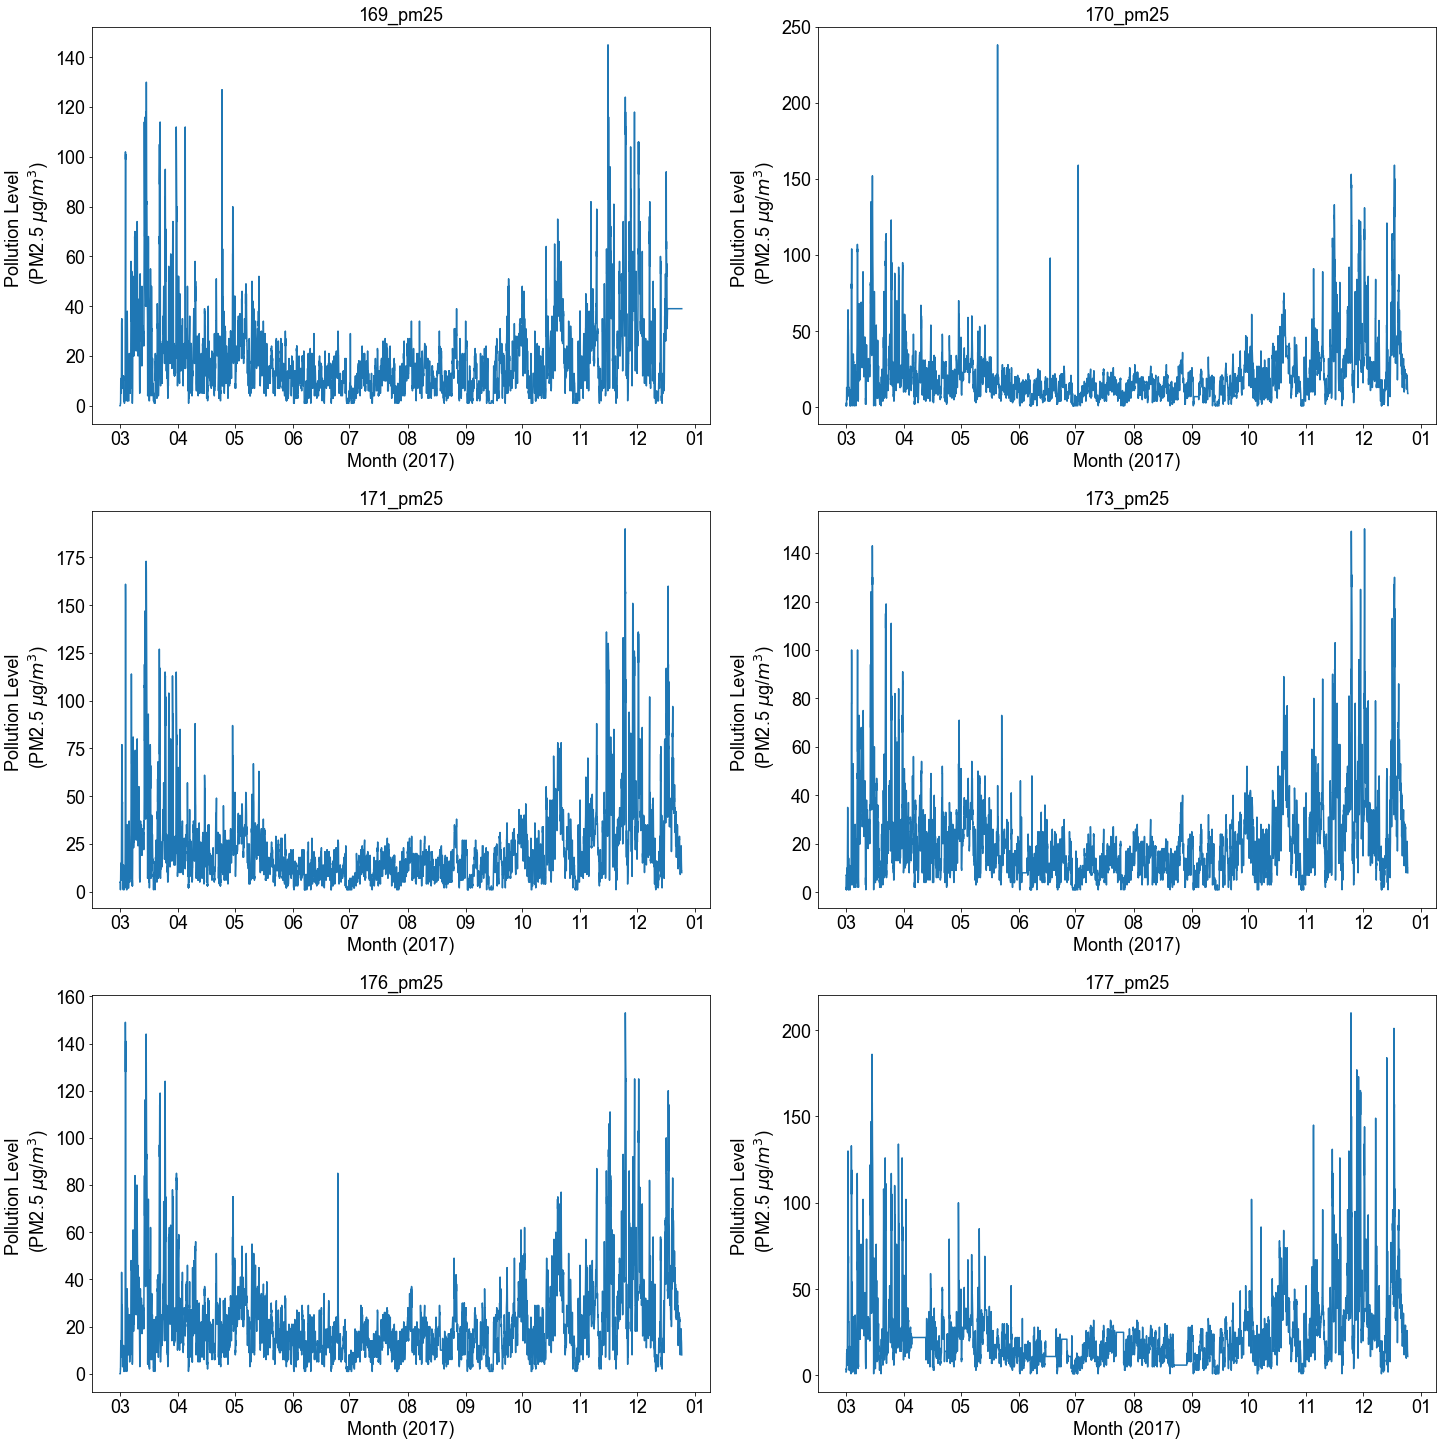

In [36]:
# PM2.5 distribution across the 6 sensors shown in orange above
# The PM2.5 concentrations are classified into 6 classes based on the plots below
# Class 1 : PM Level below 10
# Class 2 : PM Level 10 - 20
# Class 3 : PM Level 20 - 50
# Class 4 : PM Level 50 - 100
# Class 5 : PM Level 100 - 150
# Class 6 : PM Level 150 and above

rcParams['font.family'] = 'arial'
import matplotlib.dates as mdates
from scipy.signal import savgol_filter

f1 = plt.figure(figsize=(20,20))

for i in range(6):

    ax1 = f1.add_subplot(3,2,1+i)

    x = pm25['UTC time']
    y = pm25.iloc[:,i]
    ax1.plot(x,y)

    ax1.set_xlabel('Month (2017)',fontsize=18)
    ax1.set_ylabel('Pollution Level \n (PM2.5 $\mu$g/$m^{3}$)',fontsize=18)
    ax1.tick_params(axis='x', labelsize=18)
    ax1.tick_params(axis='y', labelsize=18)
    ax1.xaxis.set_major_formatter(mdates.DateFormatter("%m"))
    ax1.set_title(pm25.columns[i],fontsize=18)
    
plt.tight_layout(pad=0.4, w_pad=2, h_pad=2)
f1.savefig('pm25_6sensors.png')

In [91]:
# Splitting sensors into training and test sensors (6 test and 24 training)
# Locations of training sensors are stored in dataframe "loc_data_train"
# Locations of the test sensors are stored in dataframe "loc_data_test"

sens_test = [173,189,196,201,222,228]
sens_train = [169,170,171,176,177,179,181,182,183,184,192,194,204,212,214,215,218,219,220,221,223,225,226,263]

loc_data_train = loc_data[loc_data['id'].isin(sens_train)]
loc_data_test = loc_data[loc_data['id'].isin(sens_test)]

In [92]:
# Checking distance in km between the farthest sensors 

from math import sin, cos, sqrt, atan2, radians

lat1 = radians(loc_data_train['latitude'].max())
lat2 = radians(loc_data_train['latitude'].min())

lon1 = radians(loc_data_train['longitude'].max())
lon2 = radians(loc_data_train['longitude'].min())

dlat = lat2 - lat1
dlon = lon2 - lon1

R = 6373.0
a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
c = 2 * atan2(sqrt(a), sqrt(1 - a))
R * c

23.047275777807464

In [93]:
# Selecting end points of the grid in which PM2.5 levels will be evaluated

# Max and Min longtude and latitudes are selected 

lon_min = 19.82
lon_max = 20.102
lat_max = 50.109
lat_min = 49.998

# Distance between min and max longtudes is calculated

bottomLeft = (19.82, 49.998)
bottomRight = (20.102, 49.998)
topLeft = (19.82, 50.109)
topRight = (20.102, 50.109)


from math import sin, cos, sqrt, atan2, radians

lat1 = radians(bottomLeft[1])
lat2 = radians(bottomRight[1])

lon1 = radians(bottomLeft[0])
lon2 = radians(bottomRight[0])

dlat = lat2 - lat1
dlon = lon2 - lon1

R = 6373.0
a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
c = 2 * atan2(sqrt(a), sqrt(1 - a))
R * c

20.163025527010152

In [94]:
# A grid having 20 ponts along the longitude and 12 points along the latitude is created
# The grid has a total of 240 points
# The longitudes are converted to x and latitudes are converted to y

import numpy as np 
cols = np.linspace(bottomLeft[0], bottomRight[0], num=21)
rows = np.linspace(bottomLeft[1], topLeft[1], num=13)


# Training and test data are provided with x,y location based on the grid and their corresponding latitudes and longitudes

loc_data_train['x'] = np.searchsorted(cols, loc_data_train['longitude'])
loc_data_train['y'] = np.searchsorted(rows, loc_data_train['latitude'])

loc_data_test['x'] = np.searchsorted(cols, loc_data_test['longitude'])
loc_data_test['y'] = np.searchsorted(rows, loc_data_test['latitude'])

C:\Users\IVN\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\Users\IVN\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\Users\IVN\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexin

In [95]:
# x,y coordinates of training sensors based on grid definition and their corresponding latitudes and longitudes 
# are stored in dataframe "loc_data_train"
# For test sensors, the same information is stored in dataframe "loc_data_test"

loc_data_train

,id,latitude,longitude,x,y
4,169,50.048699,20.101569,20,6
5,170,50.077467,19.895577,6,9
6,171,50.084134,19.968416,11,10
10,176,50.044067,19.998804,13,5
11,177,50.093619,19.924138,8,11
13,179,50.077690,19.935777,9,9
15,181,50.055163,19.947015,10,7
16,182,50.020586,20.022960,15,3
17,183,50.098304,19.879415,5,11
18,184,50.047736,19.919646,8,6


In [96]:
# Each of the 240 points in the grid is assigned a latitude and longitude

from scipy.interpolate import griddata
Lats_grid, Long_grid = np.meshgrid( (rows[1:] + rows[:12]) / 2 , (cols[1:] + cols[:20]) / 2 )

In [97]:
# Latitude and Longitude data for Training and Test sensors in stored in lists 
# "lats_train", "lons_train", "lats_test" and "lons_test"

lats_train = loc_data_train['latitude'].tolist()
lons_train = loc_data_train['longitude'].tolist()

lats_test = loc_data_test['latitude'].tolist()
lons_test = loc_data_test['longitude'].tolist()

In [98]:
# 6 test sensors are plotted in orange and 24 training sensors are plotted in blue on a location map

import plotly 
plotly.tools.set_credentials_file(username='gauravsm', api_key='yDhHOD5ueKUYqYb9xKpo')


import plotly.plotly as py
import plotly.graph_objs as go

mapbox_access_token = 'pk.eyJ1IjoiZ2F1cmF2c20iLCJhIjoiY2p2YzQ1dmtuMG02MzN5cDg1d3dsemttaCJ9.lV389_9mffK9Nk4O6Nzv_A'

#datas = []

data1 = [
    go.Scattermapbox(
        lat=lats_train,
        lon=lons_train,
        mode='markers',
        marker=go.scattermapbox.Marker(
            size=14
        ),
        text=loc_data_train['id'].to_list(),
        name = 'Train'
    ),
    
]

data2 = [
    go.Scattermapbox(
        lat=lats_test,
        lon=lons_test,
        mode='markers',
        marker=go.scattermapbox.Marker(
            size=14
        ),
        text=loc_data_test['id'].to_list(),
        name = 'Test'
    ),
    
]

data = data1 + data2

layout = go.Layout(
    title = 'Sensors',
    autosize=True,
    hovermode='closest',
    #showlegend = False,
    mapbox=go.layout.Mapbox(
        accesstoken=mapbox_access_token,
        bearing=0,
        center=go.layout.mapbox.Center(
            lat=50.057748,
            lon=19.961375
        ),
        pitch=0,
        zoom=9.8
    ),

)

fig = go.Figure(data, layout=layout)
py.iplot(fig, filename='Krakow Grid')

In [99]:
# Splitting sensors into training and test sensors (6 test and 24 training)
# ids of training sensors are stored in list "sens_train"
# ids of test sensors are stored in list "sens_test"

sens_test = [173,189,196,201,222,228]
sens_test = str(sens_test)
sens_train = [169,170,171,176,177,179,181,182,183,184,192,194,204,212,214,215,218,219,220,221,223,225,226,263]
sens_train = str(sens_train)

In [100]:
# Selecting temp, pres, hum, pm25 and pm10 data for training sensors and storing in a dataframes "temp_trainLoc", "pres_trainLoc",
# "hum_trainLoc", "pm25_trainLoc" and "pm10_trainLoc"


cols = [c for c in temp.columns if c.lower()[:3] in sens_train]
cols = cols + ['UTC time']
temp_trainLoc = temp[cols]

cols = [c for c in pres.columns if c.lower()[:3] in sens_train]
cols = cols + ['UTC time']
pres_trainLoc = pres[cols]

cols = [c for c in hum.columns if c.lower()[:3] in sens_train]
cols = cols + ['UTC time']
hum_trainLoc = hum[cols]

cols = [c for c in pm25.columns if c.lower()[:3] in sens_train]
cols = cols + ['UTC time']
pm25_trainLoc = pm25[cols]

cols = [c for c in pm10.columns if c.lower()[:3] in sens_train]
cols = cols + ['UTC time']
pm10_trainLoc = pm10[cols]

In [101]:
# Storing location data of training sensors in an array "points" of size (24, 2)

from scipy.interpolate import griddata
grid_x, grid_y = np.mgrid[1:21, 1:13]
points = pd.DataFrame()
points['x'] = loc_data_train['x']
points['y'] = loc_data_train['y']
points = np.array(points.values)

In [102]:
# Storing location data of all points in the grid as an array "gridxy" of size (240, 2)

gridxy = pd.DataFrame()
gridxy['x'] = np.reshape(grid_x,(grid_x.size))
gridxy['y'] = np.reshape(grid_y,(grid_y.size))
gridxy = np.array(gridxy.values)

In [103]:
# Storing location data of all points (240) except sensors (24) in the grid as an array "grid_notsensors" of size (216, 2)

A = gridxy
B = points
dims = np.maximum(B.max(0),A.max(0))+1
grid_notsensors = A[~np.in1d(np.ravel_multi_index(A.T,dims),np.ravel_multi_index(B.T,dims))]

In [178]:
# senor_idx has indices in gridxy where there are sensors
sensor_idx = np.where((A==B[:,None]).all(-1))[1]

In [64]:
# We need temperature data for all 240 points in the grid at each time instance
# We have temp values for only 24 points at each time instance
# We assign temerature value of the nearest sensor to each point at the same time instance

temp_grid = []
for i in range(temp.shape[0]-1):
    values = np.array(temp_trainLoc.iloc[i,:-1].values)
    temp_z = np.array(griddata(points, values, (grid_x, grid_y), method='nearest'))
    temp_grid = temp_grid + [np.reshape(temp_z,(1,temp_z.shape[1]*temp_z.shape[0] ))[0]]

In [65]:
# We need humidity data for all 240 points in the grid at each time instance
# We have humidity values for only 24 points at each time instance
# We assign humidity value of the nearest sensor to each point at the same time instance

hum_grid = []
for i in range(temp.shape[0]-1):
    values = np.array(hum_trainLoc.iloc[i,:-1].values)
    hum_z = np.array(griddata(points, values, (grid_x, grid_y), method='nearest'))
    hum_grid = hum_grid + [np.reshape(hum_z,(1,hum_z.shape[1] *hum_z.shape[0] ))[0]]

In [247]:
# # Finding indices in "points" of three nearest neighbor for each point in "grid_notsensors"

# from sklearn.neighbors import NearestNeighbors
# nbrs = NearestNeighbors(n_neighbors=3, algorithm='ball_tree').fit(points)
# distances, indices_notsensors = nbrs.kneighbors(grid_notsensors)

In [248]:
# Finding indices in "grixdy" of three nearest neighbor for each point in "gridxy"

from sklearn.neighbors import NearestNeighbors
nbrs = NearestNeighbors(n_neighbors=3, algorithm='ball_tree').fit(points)
distances, indices_allpoints = nbrs.kneighbors(gridxy)

In [80]:
# # Finding indices in "points" of three nearest neighbor for each point in "points"

# from sklearn.neighbors import NearestNeighbors
# nbrs = NearestNeighbors(n_neighbors=4, algorithm='ball_tree').fit(points)
# distances, indices = nbrs.kneighbors(points)
# indices_sensors = indices[:,[1,2,3]]

In [81]:
# # Selecting pm25 values of the first nearest sensor location exluding self for all 240 points in the grid

# pm25_grid_N1 = []
# for i in range(temp.shape[0]-1):
#     values = np.array(pm25_trainLoc.iloc[i,:-1].values)
    
#     # Selecting pm25 values of first nearest sensor for non sensor locations
    
#     pm25_values_notsensors = np.zeros((grid_notsensors.shape[0],1))
#     for i in range(pm25_values_notsensors.shape[0]):
#         pm25_values_notsensors[i,0] = values[indices_notsensors[i,0]]
            
#     # Selecting pm25 values of first nearest sensor for sensor locations excluding self

#     pm25_values_sensors = np.zeros((points.shape[0],1))
#     for i in range(pm25_values_sensors.shape[0]):
#         pm25_values_sensors[i,0] = values[indices_sensors[i,0]]
    
#     # Stacking grids of first nearest neighbor values for each time instance
        
#     pm25_z = np.array(griddata(np.append(grid_notsensors,points,axis=0), np.append(pm25_values_notsensors,pm25_values_sensors,axis=0), (grid_x, grid_y), method='cubic'))
#     pm25_grid_N1 = pm25_grid_N1 + [np.reshape(pm25_z,(1,pm25_z.shape[1]*pm25_z.shape[0] ))[0]]

In [249]:
# Selecting pm25 values of the first nearest sensor location for all 240 points in the grid

pm25_grid_N1 = []
for i in range(temp.shape[0]-1):
    values = np.array(pm25_trainLoc.iloc[i,:-1].values)
    
    # Selecting pm25 values of first nearest sensor for all locations
    
    pm25_values= np.zeros((gridxy.shape[0],1))
    for i in range(pm25_values.shape[0]):
        pm25_values[i,0] = values[indices_allpoints[i,0]]
    
    # Stacking grids of first nearest neighbor values for each time instance
        
    pm25_z = np.array(griddata(gridxy, pm25_values, (grid_x, grid_y), method='cubic'))
    pm25_grid_N1 = pm25_grid_N1 + [np.reshape(pm25_z,(1,pm25_z.shape[1]*pm25_z.shape[0] ))[0]]

In [85]:
# # Selecting pm25 values of the second nearest sensor location exluding self for all 240 points in the grid

# pm25_grid_N2 = []
# for i in range(temp.shape[0]-1):
#     values = np.array(pm25_trainLoc.iloc[i,:-1].values)
    
#     # Selecting pm25 values of second nearest sensor for non sensor locations
    
#     pm25_values_notsensors = np.zeros((grid_notsensors.shape[0],1))
#     for i in range(pm25_values_notsensors.shape[0]):
#         pm25_values_notsensors[i,0] = values[indices_notsensors[i,1]]
            
#     # Selecting pm25 values of second nearest sensor for sensor locations excluding self

#     pm25_values_sensors = np.zeros((points.shape[0],1))
#     for i in range(pm25_values_sensors.shape[0]):
#         pm25_values_sensors[i,0] = values[indices_sensors[i,1]]
    
#     # Stacking grids of first nearest neighbor values for each time instance
        
#     pm25_z = np.array(griddata(np.append(grid_notsensors,points,axis=0), np.append(pm25_values_notsensors,pm25_values_sensors,axis=0), (grid_x, grid_y), method='cubic'))
#     pm25_grid_N2 = pm25_grid_N2 + [np.reshape(pm25_z,(1,pm25_z.shape[1]*pm25_z.shape[0] ))[0]]

In [250]:
# Selecting pm25 values of the SECOND nearest sensor location for all 240 points in the grid

pm25_grid_N2 = []
for i in range(temp.shape[0]-1):
    values = np.array(pm25_trainLoc.iloc[i,:-1].values)
    
    # Selecting pm25 values of first nearest sensor for all locations
    
    pm25_values= np.zeros((gridxy.shape[0],1))
    for i in range(pm25_values.shape[0]):
        pm25_values[i,0] = values[indices_allpoints[i,1]]
    
    # Stacking grids of first nearest neighbor values for each time instance
        
    pm25_z = np.array(griddata(gridxy, pm25_values, (grid_x, grid_y), method='cubic'))
    pm25_grid_N2 = pm25_grid_N2 + [np.reshape(pm25_z,(1,pm25_z.shape[1]*pm25_z.shape[0] ))[0]]

In [86]:
# # Selecting pm25 values of the third nearest sensor location exluding self for all 240 points in the grid

# pm25_grid_N3 = []
# for i in range(temp.shape[0]-1):
#     values = np.array(pm25_trainLoc.iloc[i,:-1].values)
    
#     # Selecting pm25 values of third nearest sensor for non sensor locations
    
#     pm25_values_notsensors = np.zeros((grid_notsensors.shape[0],1))
#     for i in range(pm25_values_notsensors.shape[0]):
#         pm25_values_notsensors[i,0] = values[indices_notsensors[i,2]]
            
#     # Selecting pm25 values of third nearest sensor for sensor locations excluding self

#     pm25_values_sensors = np.zeros((points.shape[0],1))
#     for i in range(pm25_values_sensors.shape[0]):
#         pm25_values_sensors[i,0] = values[indices_sensors[i,2]]
    
#     # Stacking grids of first nearest neighbor values for each time instance
        
#     pm25_z = np.array(griddata(np.append(grid_notsensors,points,axis=0), np.append(pm25_values_notsensors,pm25_values_sensors,axis=0), (grid_x, grid_y), method='cubic'))
#     pm25_grid_N3 = pm25_grid_N3 + [np.reshape(pm25_z,(1,pm25_z.shape[1]*pm25_z.shape[0] ))[0]]

In [251]:
# Selecting pm25 values of the THIRD nearest sensor location for all 240 points in the grid

pm25_grid_N3 = []
for i in range(temp.shape[0]-1):
    values = np.array(pm25_trainLoc.iloc[i,:-1].values)
    
    # Selecting pm25 values of first nearest sensor for all locations
    
    pm25_values= np.zeros((gridxy.shape[0],1))
    for i in range(pm25_values.shape[0]):
        pm25_values[i,0] = values[indices_allpoints[i,2]]
    
    # Stacking grids of first nearest neighbor values for each time instance
        
    pm25_z = np.array(griddata(gridxy, pm25_values, (grid_x, grid_y), method='cubic'))
    pm25_grid_N3 = pm25_grid_N3 + [np.reshape(pm25_z,(1,pm25_z.shape[1]*pm25_z.shape[0] ))[0]]

In [252]:
# Converting list data to array for temp, hum, pm25 values of first second and third nearest sensor 

temp_grid = np.array(temp_grid)
hum_grid = np.array(hum_grid)
pm25_grid_N1 = np.array(pm25_grid_N1)
pm25_grid_N2 = np.array(pm25_grid_N2)
pm25_grid_N3 = np.array(pm25_grid_N3)

In [106]:
# Plotting a time instance of temperature at the sensors

Z = np.array(temp_trainLoc.iloc[3000][:-1].tolist())

import plotly 
plotly.tools.set_credentials_file(username='gauravsm', api_key='yDhHOD5ueKUYqYb9xKpo')


import plotly.plotly as py
import plotly.graph_objs as go

mapbox_access_token = 'pk.eyJ1IjoiZ2F1cmF2c20iLCJhIjoiY2p2YzQ1dmtuMG02MzN5cDg1d3dsemttaCJ9.lV389_9mffK9Nk4O6Nzv_A'

limits = [(-20,0),(0,10),(10,20),(20,30),(30,50)]
colors = ["rgb(204,255,255)","rgb(0,116,217)","rgb(255,133,27)","rgb(255,65,54)","rgb(133,20,75)"]
cities = []
scale = 5000
lats=np.array(lats_train)
lons=np.array(lons_train)


for i in range(len(limits)-1):
    lim = limits[i]
    idx = np.where(np.logical_and(Z>=lim[0], Z<lim[1]))[0]
    city = go.Scattermapbox(
        lon = lons[idx],
        lat = lats[idx],
        mode='markers',
        marker=go.scattermapbox.Marker(
            size=14,
            color = colors[i],
        ),
        name = '{0} - {1}'.format(lim[0],lim[1]) 
    
    )
    cities.append(city)
    
i=i+1    
lim = limits[i]
idx = np.where(np.logical_and(Z>=lim[0], Z<=lim[1]))[0]
city = go.Scattermapbox(
    lon = lons[idx],
    lat = lats[idx],
    mode='markers',
    marker=go.scattermapbox.Marker(
        size=14,
        color = colors[i],
    ),
    name = '{0} - {1}'.format(lim[0],lim[1]) 

)
cities.append(city)

layout = go.Layout(
    title = 'Temp Distribution',
    autosize=True,
    hovermode='closest',
    showlegend = True,
    mapbox=go.layout.Mapbox(
        accesstoken=mapbox_access_token,
        bearing=0,
        center=go.layout.mapbox.Center(
            lat=50.057748,
            lon=19.961375
        ),
        pitch=0,
        zoom=9.8
    ),

)

fig = go.Figure(data=cities, layout=layout)
py.iplot(fig, filename='d3-bubble-map-populations')

In [107]:
# Interpolating temperature at the above time instance using nearest neighbor
# This assigns temperature value to all points in gridxy


Z = np.reshape(temp_grid[3000],(grid_x.shape[0],grid_x.shape[1]))

import plotly 
plotly.tools.set_credentials_file(username='gauravsm', api_key='yDhHOD5ueKUYqYb9xKpo')


import plotly.plotly as py
import plotly.graph_objs as go

mapbox_access_token = 'pk.eyJ1IjoiZ2F1cmF2c20iLCJhIjoiY2p2YzQ1dmtuMG02MzN5cDg1d3dsemttaCJ9.lV389_9mffK9Nk4O6Nzv_A'

limits = [(-20,0),(0,10),(10,20),(20,30),(30,50)]
colors = ["rgb(204,255,255)","rgb(0,116,217)","rgb(255,133,27)","rgb(255,65,54)","rgb(133,20,75)"]
cities = []
scale = 5000


for i in range(len(limits)):
    lim = limits[i]
    indx, indy = np.where(np.logical_and(Z>=lim[0], Z<lim[1]))
    city = go.Scattermapbox(
        lon = Long_grid[indx,indy],
        lat = Lats_grid[indx,indy],
        mode='markers',
        marker=go.scattermapbox.Marker(
            size=14,
            color = colors[i],
        ),
        name = '{0} - {1}'.format(lim[0],lim[1]) 
    
    )
    cities.append(city)

layout = go.Layout(
    title = 'Temp Distribution',
    autosize=True,
    hovermode='closest',
    showlegend = True,
    mapbox=go.layout.Mapbox(
        accesstoken=mapbox_access_token,
        bearing=0,
        center=go.layout.mapbox.Center(
            lat=50.057748,
            lon=19.961375
        ),
        pitch=0,
        zoom=9.8
    ),

)

fig = go.Figure(data=cities, layout=layout)
py.iplot(fig, filename='d3-bubble-map-populations')

In [108]:
# Plotting a time instance of pm25 at the sensors

Z = np.array(pm25_trainLoc.iloc[3000][:-1].tolist())


import plotly 
plotly.tools.set_credentials_file(username='gauravsm', api_key='yDhHOD5ueKUYqYb9xKpo')


import plotly.plotly as py
import plotly.graph_objs as go

mapbox_access_token = 'pk.eyJ1IjoiZ2F1cmF2c20iLCJhIjoiY2p2YzQ1dmtuMG02MzN5cDg1d3dsemttaCJ9.lV389_9mffK9Nk4O6Nzv_A'

limits = [(0,10),(10,20),(20,50),(50,100),(100,150),(150,500)]
colors = ["rgb(204,255,255)","rgb(0,116,217)","rgb(255,133,27)","rgb(255,65,54)","rgb(133,20,75)","rgb(133,20,95)"]
cities = []
scale = 5000

lats=np.array(lats_train)
lons=np.array(lons_train)


for i in range(len(limits)-1):
    lim = limits[i]
    idx = np.where(np.logical_and(Z>=lim[0], Z<lim[1]))[0]
    city = go.Scattermapbox(
        lon = lons[idx],
        lat = lats[idx],
        mode='markers',
        marker=go.scattermapbox.Marker(
            size=14,
            color = colors[i],
        ),
        name = '{0} - {1}'.format(lim[0],lim[1]) 
    
    )
    cities.append(city)
    
i=i+1    
lim = limits[i]
idx = np.where(np.logical_and(Z>=lim[0], Z<=lim[1]))[0]
city = go.Scattermapbox(
    lon = lons[idx],
    lat = lats[idx],
    mode='markers',
    marker=go.scattermapbox.Marker(
        size=14,
        color = colors[i],
    ),
    name = '{0} - {1}'.format(lim[0],lim[1]) 

)
cities.append(city)

layout = go.Layout(
    title = 'PM 2.5 Distribution',
    autosize=True,
    hovermode='closest',
    showlegend = True,
    mapbox=go.layout.Mapbox(
        accesstoken=mapbox_access_token,
        bearing=0,
        center=go.layout.mapbox.Center(
            lat=50.057748,
            lon=19.961375
        ),
        pitch=0,
        zoom=9.8
    ),

)

fig = go.Figure(data=cities, layout=layout)
py.iplot(fig, filename='d3-bubble-map-populations')

In [255]:
# Interpolating pm25 at the above time instance using first nearest neighbor excluding self
# This assigns first pm25 value to all points in gridxy
# We assign three pm25 values to all points in gridxy


Z = np.reshape(pm25_grid_N1[3000],(grid_x.shape[0],grid_x.shape[1]))

import plotly 
plotly.tools.set_credentials_file(username='gauravsm', api_key='yDhHOD5ueKUYqYb9xKpo')


import plotly.plotly as py
import plotly.graph_objs as go

mapbox_access_token = 'pk.eyJ1IjoiZ2F1cmF2c20iLCJhIjoiY2p2YzQ1dmtuMG02MzN5cDg1d3dsemttaCJ9.lV389_9mffK9Nk4O6Nzv_A'

limits = [(0,10),(10,20),(20,50),(50,100),(100,150),(150,500)]
colors = ["rgb(204,255,255)","rgb(0,116,217)","rgb(255,133,27)","rgb(255,65,54)","rgb(133,20,75)","rgb(133,20,95)"]
cities = []
scale = 5000

lats=np.array(lats_train)
lons=np.array(lons_train)

for i in range(len(limits)):
    lim = limits[i]
    indx, indy = np.where(np.logical_and(Z>=lim[0], Z<lim[1]))
    city = go.Scattermapbox(
        lon = Long_grid[indx,indy],
        lat = Lats_grid[indx,indy],
        mode='markers',
        marker=go.scattermapbox.Marker(
            size=14,
            color = colors[i],
        ),
        name = '{0} - {1}'.format(lim[0],lim[1]) 
    
    )
    cities.append(city)

layout = go.Layout(
    title = 'PM 2.5 Distribution',
    autosize=True,
    hovermode='closest',
    showlegend = True,
    mapbox=go.layout.Mapbox(
        accesstoken=mapbox_access_token,
        bearing=0,
        center=go.layout.mapbox.Center(
            lat=50.057748,
            lon=19.961375
        ),
        pitch=0,
        zoom=9.8
    ),

)

fig = go.Figure(data=cities, layout=layout)
py.iplot(fig, filename='d3-bubble-map-populations')

In [115]:
# Assiging class labels to sensor location for each time instance

labels_sensors = np.zeros((pm25_trainLoc.shape[0],pm25_trainLoc.shape[1]-1))
for i in range(pm25_trainLoc.shape[0]):
    for j in range(pm25_trainLoc.shape[1]-1):
        if pm25_trainLoc.iloc[i][j] < 10:
            labels_sensors[i,j] = 0
        elif pm25_trainLoc.iloc[i][j] < 20 and pm25_trainLoc.iloc[i][j] >= 10:
            labels_sensors[i,j] = 1
        elif pm25_trainLoc.iloc[i][j] < 50 and pm25_trainLoc.iloc[i][j] >= 20:
            labels_sensors[i,j] = 2
        elif pm25_trainLoc.iloc[i][j] < 100 and pm25_trainLoc.iloc[i][j] >= 50:
            labels_sensors[i,j] = 3
        elif pm25_trainLoc.iloc[i][j] < 150 and pm25_trainLoc.iloc[i][j] >= 100:
            labels_sensors[i,j] = 4
        elif pm25_trainLoc.iloc[i][j] >= 150:
            labels_sensors[i,j] = 5

In [256]:
# Converting list data to array for temp, hum, pm25 values of first second and third nearest sensor 
# (excluding self for sensors)

temp_grid = np.array(temp_grid)
hum_grid = np.array(hum_grid)
pm25_grid_N1 = np.array(pm25_grid_N1)
pm25_grid_N2 = np.array(pm25_grid_N2)
pm25_grid_N3 = np.array(pm25_grid_N3)

In [257]:
# Selecting points with sensors

temp_grid_sensors = temp_grid[:,sensor_idx]
hum_grid_sensors = hum_grid[:,sensor_idx]
pm25_grid_N1_sensors = pm25_grid_N1[:,sensor_idx]
pm25_grid_N2_sensors = pm25_grid_N2[:,sensor_idx]
pm25_grid_N3_sensors = pm25_grid_N3[:,sensor_idx]

In [268]:
# D_sensors is the number of points in the grid with only sensors, D_sensors = 24
# D is the number of points in the grid, D = 240
# N is total number of time instances, N = 7176
D_sensors = len(pm25_grid_N1_sensors[0])
D = len(pm25_grid_N1[0])
N = len(pm25_grid_N1_sensors)

# Predict for Tf number of time instances in the future
# Have temp and hum data from time t-Tp1 to t+Tf for current time t
# Have pm25 values of 3 nearest neighbors from t-Tp2 to t for current time t 
Tf = 48
Tp1 = 11
Tp2 = 23

# d_in is dimension of input for each point in the grid at time t
d_in = 2*(Tf+Tp1+1)+1*3*(Tp2+1) 

# d_out is dimension of output for each point in the grid at time t
d_out = (Tf+1)

# n_grid is the number of time instances
n_grid = (N - Tf - Tp2)

# n_sens is the number of points when only sensor data is considered
n_sens = n_grid*D_sensors

In [269]:
# X_sens is n_sens X d_in input matrix
X_sens = np.zeros((n_sens,d_in))

In [270]:
# Filling the X_Sens matrix
for i in range(n_grid):
    i = i + Tp2
    for j in range(D_sensors):
        a1 = temp_grid_sensors[i-Tp1:i+Tf+1,j]
        a2 = hum_grid_sensors[i-Tp1:i+Tf+1,j]
        a3 = pm25_grid_N1_sensors[i-Tp2:i+1,j]
        a4 = pm25_grid_N2_sensors[i-Tp2:i+1,j]
        a5 = pm25_grid_N3_sensors[i-Tp2:i+1,j]
        a = np.concatenate((a1,a2,a3,a4,a5))
        X_sens[j+(i - Tp2)*D_sensors,:] = a

In [271]:
# Y_sens is n_sens X d_out output matrix
Y_sens = np.zeros((n_sens,d_out))

In [274]:
# Filling the Y_sens matrix
for i in range(n_grid):
    i = i + Tp2
    for j in range(D_sensors):
        Y_sens[j+(i - Tp2)*D_sensors,:] = labels_sensors[i:i+Tf+1,j]

In [245]:
ll = gnb.predict_log_proba(X_sens)
sum(ll)

array([-30422015.65696201, -17212531.91074111, -10853129.31692086,
       -27785202.4821412 , -47726291.73870198, -49685636.4917758 ])

In [140]:
# Checking code to for creating training input input 
i=50
a1 = np.reshape(temp_grid[i-Tp1:i+Tf+1], (1, temp_grid[i-Tp1:i+Tf+1].shape[0]*temp_grid[i-Tp1:i+Tf+1].shape[1] ) )
a2 = np.reshape(pres_grid[i-Tp1:i+Tf+1], (1, pres_grid[i-Tp1:i+Tf+1].shape[0]*pres_grid[i-Tp1:i+Tf+1].shape[1] ) )
a3 = np.reshape(hum_grid[i-Tp1:i+Tf+1], (1, hum_grid[i-Tp1:i+Tf+1].shape[0]*hum_grid[i-Tp1:i+Tf+1].shape[1] ) )
a4 = np.reshape(pm25_grid[i-Tp2:i+1], (1, pm25_grid[i-Tp2:i+1].shape[0]*pm25_grid[i-Tp2:i+1].shape[1] ) )
a5 = np.reshape(pm10_grid[i-Tp2:i+1], (1, pm10_grid[i-Tp2:i+1].shape[0]*pm10_grid[i-Tp2:i+1].shape[1] ) )
a = np.concatenate((a1,a2,a3,a4,a5),axis=1)

In [141]:
a.shape

(1, 7200)

In [142]:
TrainingX = np.zeros((ntrain-Tp2-Tf,dimtrain))
TrainingY = np.zeros((ntrain-Tp2-Tf,dimtrain_y))
for i in range(ntrain-Tp2-Tf):
    i = i + Tp2
    a1 = np.reshape(temp_grid[i-Tp1:i+Tf+1], (1, temp_grid[i-Tp1:i+Tf+1].shape[0]*temp_grid[i-Tp1:i+Tf+1].shape[1] ) )
    a2 = np.reshape(pres_grid[i-Tp1:i+Tf+1], (1, pres_grid[i-Tp1:i+Tf+1].shape[0]*pres_grid[i-Tp1:i+Tf+1].shape[1] ) )
    a3 = np.reshape(hum_grid[i-Tp1:i+Tf+1], (1, hum_grid[i-Tp1:i+Tf+1].shape[0]*hum_grid[i-Tp1:i+Tf+1].shape[1] ) )
    a4 = np.reshape(pm25_grid[i-Tp2:i+1], (1, pm25_grid[i-Tp2:i+1].shape[0]*pm25_grid[i-Tp2:i+1].shape[1] ) )
    a5 = np.reshape(pm10_grid[i-Tp2:i+1], (1, pm10_grid[i-Tp2:i+1].shape[0]*pm10_grid[i-Tp2:i+1].shape[1] ) )
    a = np.concatenate((a1,a2,a3,a4,a5),axis=1)
    TrainingX[i - Tp2,:] = a
    
    b1 = np.reshape(pm25_grid[i:i+1+Tf], (1, pm25_grid[i:i+1+Tf].shape[0]*pm25_grid[i:i+1+Tf].shape[1] ) )
    b2 = np.reshape(pm10_grid[i:i+1+Tf], (1, pm10_grid[i:i+1+Tf].shape[0]*pm10_grid[i:i+1+Tf].shape[1] ) )
    b = np.concatenate((b1,b2),axis=1)  
    TrainingY[i - Tp2,:] = b                                                                                    

In [143]:
# PCA

from sklearn.decomposition import PCA

pca = PCA()  
scores = pca.fit_transform(TrainingX)  
comps = pca.components_
D = pca.explained_variance_

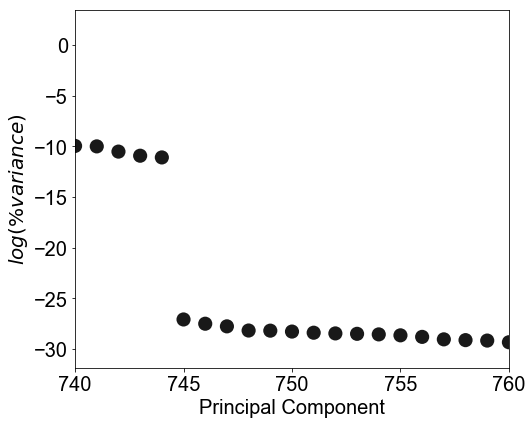

In [105]:
from matplotlib import rcParams
rcParams['font.family'] = 'arial'

f12 = plt.figure(figsize=(7.5,6))
ax1 = f12.add_subplot(1,1,1)
ax1.scatter(range(1,1001),np.log10(100*np.divide(D[:1000],sum(D))),s=200,marker="o",c='k',alpha=0.9,edgecolors='none')
ax1.set_xlabel('Principal Component',fontsize=20)
ax1.set_ylabel('$log(\%variance)$',fontsize=20)
ax1.tick_params(axis='x', labelsize=20)
ax1.tick_params(axis='y', labelsize=20)
ax1.set_xlim([740,760])
plt.tight_layout()

In [ ]:
# 10 fold Cross Validation
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler

MSE = [] 

cv = KFold(n_splits=10, random_state=42, shuffle=False)

for train_index, test_index in cv.split(TrainingX):

    X_train, X_test, y_train, y_test = TrainingX[train_index], TrainingX[test_index], TrainingY[train_index], TrainingY[test_index]
    
    
    X_train, y_train
    
    pca = PCA() 
    scores = pca.fit_transform(X_train)  
    comps = pca.components_
    D = pca.explained_variance_
    X_train_transf = scores[:,:35]
    
    scores_test = pca.transform(X_test) 
    X_test_transf = scores_test[:,:35]
    
    lm = linear_model.LinearRegression()
    model = lm.fit(X_train_transf,y_train)
    
    y_test_pred = lm.predict(X_test_transf)
    
    MSE = MSE + [ np.sqrt(np.sum(np.square( y_test_pred - y_test ))/y_test.shape[0]) ]


In [144]:
from sklearn import linear_model
# Choose the first 744 dimensions from PCA decomposition
TrainingX_transf = scores[:,:744]

# Perform Linear Regression
lm = linear_model.LinearRegression()
#model = lm.fit(TrainingX , TrainingY)

model = lm.fit(TrainingX_transf , TrainingY)

In [145]:
TestX = np.zeros((ntest-Tp2-Tf,dimtrain))
TestY = np.zeros((ntest-Tp2-Tf,dimtrain_y))
for i in range(ntest-Tp2-Tf):
    i = i + (Tp2 + ntrain)
    a1 = np.reshape(temp_grid[i-Tp1:i+Tf+1], (1, temp_grid[i-Tp1:i+Tf+1].shape[0]*temp_grid[i-Tp1:i+Tf+1].shape[1] ) )
    a2 = np.reshape(pres_grid[i-Tp1:i+Tf+1], (1, pres_grid[i-Tp1:i+Tf+1].shape[0]*pres_grid[i-Tp1:i+Tf+1].shape[1] ) )
    a3 = np.reshape(hum_grid[i-Tp1:i+Tf+1], (1, hum_grid[i-Tp1:i+Tf+1].shape[0]*hum_grid[i-Tp1:i+Tf+1].shape[1] ) )
    a4 = np.reshape(pm25_grid[i-Tp2:i+1], (1, pm25_grid[i-Tp2:i+1].shape[0]*pm25_grid[i-Tp2:i+1].shape[1] ) )
    a5 = np.reshape(pm10_grid[i-Tp2:i+1], (1, pm10_grid[i-Tp2:i+1].shape[0]*pm10_grid[i-Tp2:i+1].shape[1] ) )
    a = np.concatenate((a1,a2,a3,a4,a5),axis=1)
    TestX[i-(Tp2 + ntrain),:] = a
    
    b1 = np.reshape(pm25_grid[i:i+1+Tf], (1, pm25_grid[i:i+1+Tf].shape[0]*pm25_grid[i:i+1+Tf].shape[1] ) )
    b2 = np.reshape(pm10_grid[i:i+1+Tf], (1, pm10_grid[i:i+1+Tf].shape[0]*pm10_grid[i:i+1+Tf].shape[1] ) )
    b = np.concatenate((b1,b2),axis=1)  
    TestY[i-(Tp2 + ntrain),:] = b  

In [146]:
scores_test = pca.transform(TestX) 
TestX_transf = scores_test[:,:744]

In [147]:
# PCR
pred_TrainingY = lm.predict(TrainingX_transf)
pred_TestY = lm.predict(TestX_transf)

In [45]:
# Just Linear Regression
# pred_TrainingY = lm.predict(TrainingX)
# pred_TestY = lm.predict(TestX)

In [148]:
pred_TrainingY.shape

(5728, 1440)

In [149]:
from sklearn.metrics import r2_score
r2_train = r2_score(TrainingY, pred_TrainingY)
r2_train

0.942316369096015

In [150]:
from sklearn.metrics import r2_score
r2_test = r2_score(TestY, pred_TestY)
r2_test

0.9051516440881529